import numpy as np
import sys
import copy
import networkx as nx
from pyvis.network import Network
import plotly
import plotly.graph_objects as go
%matplotlib inline

In [2]:
#Settings:

QUIET = True #Just here so you can tell a function "QUIET" or "INVIS" and for some of these it will suppress part 
INVIS = False #of the output. For INVIS this will be graphical outputs
FORCE_VALID_GRIDS = False #Not fully implemented - may let some X and O be placed in the same square
FORCE_VALID_MOVES = False #Not fully implemented - prevents stabilizing where we can't and commuting columns illegally


In [3]:
class perm: #takes a list of integers and makes it a permutation type with standard permutation
            #group operation. Will copy argument if given a perm instead of a list datatype.
        
    def __init__(self, lst = [1]): #initialization just loads the list into the self.value
        check_if_valid(lst)
        if type(lst) == perm:
            self.value = lst.value.copy()
        else:
            self.value = lst.copy()

    def __str__(self):
        return str(self.value)
            
    def __repr__(self):
        return str(self.value)

    def __getitem__(self, i):
        return self.value[i-1]
    
    def __setitem__(self, i, val):
        self.value[i-1] = val
    
    def __mul__(self, other): #self o other as permutation composition, also loads this into the * notation so sig*phi works
        temp_sig = self.value.copy()
        temp_phi = other.value.copy()
        temp_sig, temp_phi = match_sizes(temp_sig, temp_phi)
        n = len(temp_phi)
        result = temp_sig.copy()
        for i in range(n):
            result[i] = temp_sig[temp_phi[i]-1]
        return perm(result)
    
    def __len__(self):
        return len(self.value)
    
    def __eq__(self, other): #lets us compare permutations
        if type(other) != perm:
            return False
        if self.value == other.value:
            return True
        else:
            return False

    def copy(self):
        newCopy = perm(self.value)
        return newCopy
        
    def inverse(self): #Finding sig^-1 
        result = identity_perm(len(self.value))
        for i in range(1,len(self.value)+1):
            result[self[i]] = i
        return result
        
    def __pow__(self, n): #computes sig**n and loads it into the ** notation
        temp_sig, temp_id = match_sizes(self.value.copy(), [1])
        result = perm(temp_id)
        if n >= 0:
            for i in range(n):
                result = self * result
            return result
        else:
            inv = self.inverse()
            for i in range(-n):
                result = inv * result
            return result

    def size(self):
        return len(self.value)
    
    def cycles(self):         #returns a tuple of tuples representing the cycle notation for
        cycle_collection = [] #the given permutation for example [2, 1, 3, 5, 6, 4] --> ((1, 2)(3)(4,5,6)
        counted = []
        for x in range(self.size()):
            current = x + 1
            current_cycle = []
            while current not in counted:
                current_cycle.append(current)
                counted.append(current)
                current = self.value[current - 1]
            if len(current_cycle) > 0:
                cycle_collection.append(tuple(current_cycle))
        return tuple(cycle_collection)
    
    def reduce_at(self, position): #removes an element that maps to itself and renumbers the permutation so its consistent
        if self.value[position - 1] == position:
            result = []
            for x in self.value:
                if x < position:
                    result.append(x)
                elif x > position:
                    result.append(x-1)
            return perm(result)
        else:
            raise ValueError("Cannot reduce at given value - given value is not fixed under the permutation")
                    
    def collapse_at(self, position): #pass this function the i s.t. you want to remove sigma(i)
        original_value = self.value[position - 1]
        result = []
        reference = self.value.copy()
        for x in reference:
            if x < original_value:
                result.append(x)
            elif x > original_value:
                result.append(x - 1)
        return perm(result)
    
    def widen_at(self, position = 1, value = 1):  #inverse of the reduce function - widens a permutation by adding i -> i in
        reference = self.value.copy()  #the middle of a permutation and renumbers the inputs and outputs that are
        size = len(reference)+1        # larger than i accordingly.
        reference.append(size)         # Ex: [1, 3, 4, 6, 2, 5] widen at 4 --> [1, 3, 5, 4, 7, 2, 6]
        result = []                    #This operation isn't very natural in permutations but it is in the context of grids
        for i in range(size):
            if i+1 < position:
                if reference[i] < value:
                    result.append(reference[i])
                else:
                    result.append(reference[i]+1)
            elif i+1 > position:
                if reference[i-1] < value:
                    result.append(reference[i-1])
                else:
                    result.append(reference[i-1]+1)                
            else:
                result.append(value)
        return perm(result)

def identity_perm(n): #produces perm data type of [1, 2, 3 ... n]
    temp_list = []
    for i in range(n):
        temp_list.append(i+1)
    return perm(temp_list)

def extend_perm(sig, n, isPerm = False): #Extends a permutation to length n - will not shorten a given permutation
    check_if_valid(sig)                  #accepts lists and perms returning the same type as given
    if type(sig) == list:
        size = len(sig)
        if n <= size:
            if isPerm:
                return perm(sig)
            return sig
        extended_perm = sig
        for i in range(size+1, n+1):
            extended_perm.append(i)
        if isPerm:
            return perm(extended_perm)
        return extended_perm
    else:
        return extend_perm(sig.value, n, True)

def match_sizes(sigma, phi): #extends the sigma and phi as necessary, adding elements mapping to themselves
    check_if_valid(sigma)    #accepts lists and perms returning the same type as given
    check_if_valid(phi)
    new_sigma = perm(sigma)
    new_phi = perm(phi)
    fin_sigma = extend_perm(new_sigma, len(phi))
    fin_phi = extend_perm(new_phi, len(sigma))
    return (type(sigma)(fin_sigma.value), type(phi)(fin_phi.value))

def check_if_valid(sig): #Running collection of possible errors for given permutation arguments
    if not ((type(sig) == list) or (type(sig) == perm)): #checks if sig is a list or a perm type and raises a warning if not
        raise ValueError("Neither list nor perm passed to function")
        
def transposition(x, y, n = 2): #Permutation of [1,2 ... y ... x ... n] just swapping x and y
    temp_list = []
    for i in range(n):
        temp_list.append(i+1)  
    temp_list[x-1] = y
    temp_list[y-1] = x
    return perm(temp_list)

def generate_all_transpositions(n):
    temp_list = []
    for x in range(1,n):
        for y in range(x+1,n+1):
            temp_list.append(transposition(x,y,n))
#            print("transposing x = " + str(x) + " and y = " + str(y))
    return temp_list

def generate_all_labeled_transpositions(n):
    temp_list = []
    for x in range(1,n):
        for y in range(x+1,n+1):
            temp_list.append([transposition(x,y,n), [x,y]])
    return temp_list

def generate_sn(n):
    ref = list(range(1,n+1))
    temp_list = []
    working_x = []
    hold = []
    for x in range(1,n+1):
        temp_list.append([x])
    for i in range(n-1):
        print(i)
        for z in range(1,n+1):
            for x in temp_list:
                if z not in x:
                    working_x = x.copy()
                    working_x.append(z)
                    hold.append(working_x)
        temp_list = hold.copy()
        hold = []
    result = []
    for entry in temp_list:
        result.append(perm(entry))
    return result

        
def full_cycle(n): #permutation of [1, 2, 3, ... n]
    result = []
    for i in range(n-1):
        result.append(i+2)
    result.append(1)
    return perm(result)

def perm_from_cycle(cycle, given_size = -1): #takes a TUPLE of TUPLES so make sure to include commas if either of those tuples has a single element
    size = 0              #currently broken - doesn't handled duplicate instances of an element -- requires reduced cycles
    if given_size == -1:
        for sub_cycle in cycle:
            for x in sub_cycle:
                if x > size:
                    size = x
    else:
        size = given_size
    temp_sig = []
    for i in range(size):
        temp_sig.append(i+1)
    for sub_cycle in cycle:
        for i in range(len(sub_cycle)):
            temp_sig[sub_cycle[i-1]-1] = sub_cycle[i]
    return perm(temp_sig)



In [4]:
import matplotlib.pyplot as plt  #code necessary for the grid diagram printing written by Evan Bell from SURIEM 2021 - saving here in case
import itertools                 #I decide to duplicate the functionality here
from scipy.optimize import curve_fit
from collections import defaultdict
import networkx as nx
from numba import jit
from numba import njit
%matplotlib inline

# Function to create a grid diagram given permutations of X and O positions
def display_grid(x_list, o_list):
    # Getting the size of the grid
    if len(x_list) == len(o_list):
        n = len(x_list)
    else:
        print('The length of the index lists do not match.')
    
    # Initializing figure and making gridlines
    plt.figure(figsize=(10*n/6,10*n/6))
    plt.vlines(range(2,n+1), ymin=1, ymax=n+1, zorder=8, color='gray', linewidth=3)
    plt.hlines(range(2,n+1), xmin=1, xmax=n+1, zorder=10.5, color='gray', linewidth=3)
    
    # Placing the X's and O's
    plt.scatter(np.arange(1, n+1)+0.5, np.array(x_list)+0.5, marker='x', s=1500, linewidth=5, c='black')
    plt.scatter(np.arange(1, n+1)+0.5, np.array(o_list)+0.5, marker='o', s=2000, linewidth=5, c='black')
    plt.scatter(np.arange(1, n+1)+0.5, np.array(o_list)+0.5, marker='o', s=1200, linewidth=5, c='white')

    # Drawing arrows
    for x, y, i in zip(x_list, o_list, range(1, n+1)):
        if x>y: # Downward pointing arrows
            plt.arrow(i+0.5, x+0.25, 0, y-x+.6, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=11)
            plt.arrow(i+0.5, x+0.25, 0, y-x+.6, width=0.15, head_width=0.2, color='white', length_includes_head=True, zorder=10)
        if x<y: # Upward pointing arrows
            plt.arrow(i+0.5, x+0.75, 0, y-x-0.6, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=11)
            plt.arrow(i+0.5, x+0.75, 0, y-x-0.6, width=0.15, head_width=0.2, color='white', length_includes_head=True, zorder=10)
        if o_list.index(i)<x_list.index(i): # Rightward pointing arrows
            plt.arrow(o_list.index(i)+1.85, i+0.5, x_list.index(i)-o_list.index(i)-0.55, 0, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=9)
        if o_list.index(i)>x_list.index(i): # Leftward pointing arrows
            plt.arrow(o_list.index(i)+1.15, i+0.5, x_list.index(i)-o_list.index(i)+0.55, 0, width=0.05, head_width=0.2, color='black', length_includes_head=True, zorder=9)
    
    # Setting up the rest of the plot
    plt.xlim(1, n+1)
    plt.ylim(1, n+1)
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False) # https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
      

In [5]:
STAB_DIRS = ["NE","NW","SW","SE"]

class grid:      #Carries knot data - functions asking for a knot (unless otherwise specified)  
                 #are asking for a grid
        
    def __init__(self, given_x, given_o, check_grid_conditions = FORCE_VALID_GRIDS): #Loads grid information into the object and confirms the grid size is square
        check_if_valid(given_x)
        check_if_valid(given_o)
        self.sig_x = perm(given_x)
        self.sig_o = perm(given_o)
        self.size = perm(given_x).size()
        if self.size != perm(given_o).size():
            raise ValueError("Grid dimensions are not equal to eachother")
        if check_grid_conditions:
            for i in self.size:
                if self.sig_x.value[i] == self.sig_o.value[i]:
                    raise ValueError("Invalid grid - X and O appear in the same square")
                
    def __repr__(self, hide=INVIS):
        if not QUIET:
            print("sig_x: " + str(self.sig_x))
            print("sig_o: " + str(self.sig_o))
        if not hide:
            display_grid(self.sig_x.value, self.sig_o.value)
        return str([self.sig_x,self.sig_o])

    def show(self):
        display_grid(self.sig_x.value, self.sig_o.value)
        return
    
    def __str__(self):
        return (str(self.sig_x)+str(self.sig_o))
    
    def h_cycle(self, n = 1): #cycles the grid as a toroidal diagram horizontally n (negative to the left) times
        cycler = full_cycle(self.size)
        print(cycler)
        new_sig_x = self.sig_x*((cycler)**n)
        new_sig_o = self.sig_o*((cycler)**n)
        return grid(new_sig_x, new_sig_o)
    
    def v_cycle(self, n = 1): #cycles the grid as a toroidal diagram vertically n (negative down) times
        cycler = full_cycle(n)
        new_sig_x = ((cycler)**n)*self.sig_x
        new_sig_o = ((cycler)**n)*self.sig_o
        return grid(new_sig_x, new_sig_o)
        
    def x_stab(self, x_choice, direction = "NW"): #grid stabilization at an x - essentially splits that x into two rows and columns
                                                  #this makes for 4 (valid) ways to fill in the gaps, NW,NE,SE,SW
        h_switch = perm_from_cycle(((x_choice, x_choice+1),), self.size+1)
        v_switch = perm_from_cycle(((self.sig_x[x_choice],self.sig_x[(x_choice)]+1),), self.size+1)
        temp_sig_x = self.sig_x.widen_at(x_choice, self.sig_x[(x_choice)])
        temp_sig_o = self.sig_o.widen_at(x_choice, self.sig_x[(x_choice)])
        if direction == "NW":
            temp_sig_o = temp_sig_o*h_switch
            return grid(temp_sig_x,temp_sig_o)
        if direction == "NE":
            temp_sig_x = temp_sig_x*h_switch
            return grid(temp_sig_x,temp_sig_o)
        if direction == "SE":
            temp_sig_x = temp_sig_x
            temp_sig_o = v_switch*temp_sig_o
            return grid(temp_sig_x,temp_sig_o)
        if direction == "SW":
            temp_sig_x = temp_sig_x*h_switch
            temp_sig_o = v_switch*(temp_sig_o*h_switch)
            return grid(temp_sig_x,temp_sig_o)

    def x_destab(self, x_choice, check_if_legal = FORCE_VALID_MOVES): #still need to work out how to check for legality - ie see if the place
        height = self.sig_x[x_choice]                                 #we destabilize at is one of NE NW SE SW.
        x_temp = self.sig_x.collapse_at(x_choice)
        helper = perm_from_cycle(((height,self.sig_o[x_choice]),),self.size)
        o_temp = self.sig_o
        o_temp = (helper*o_temp).collapse_at(x_choice)
        return grid(x_temp, o_temp)

    def __hash__(self):
        identifier = ''
        for x in self.sig_x:
            identifier = identifier + str(x)
        for o in self.sig_o:
            identifier = identifier + str(o)
        return int(identifier)    
    
    
    def commute_columns(self, left_position, ValidGridMove = FORCE_VALID_MOVES):
        h_switch = perm_from_cycle(((left_position, left_position+1),), self.size)
        new_sig_x = self.sig_x*h_switch
        new_sig_o = self.sig_o*h_switch
        return grid(new_sig_x, new_sig_o)
        
    def __eq__(self, other):
        if type(other) != grid:
            return False
        if self.sig_x == other.sig_x:
            if self.sig_o == other.sig_o:
                return True
        return False

#END OF GRID TYPE DEFINITION    
    
    
def generate_all_grids(n):     #this is (as far as I can tell) tied to derangements, which is an NP-complete problem so this won't be
    perm_set = generate_sn(n)  #able to be incredibly optimized
    hold = []
    for element in perm_set:
        for other in perm_set:
            sudokurule = True
            for i in range(n):
                if element[i+1] == other[i+1]:
                    sudokurule = False
                    break
            if sudokurule:
                hold.append(grid(element,other))
    return hold



In [6]:
#naming some common knots
trefoil = grid([5, 1, 2, 3, 4], [2, 3, 4, 5, 1])
unknot = grid([1,2],[2,1])
figureEight = grid([5,4,1,6,2,3],[2,6,5,3,4,1])
conway = grid([1,2,4,8,5,7,6,10,3,9,11],[4,5,10,3,1,11,9,8,7,2,6])


In [7]:
def Grid_Chain_Complex(knot):
    n = knot.size
    gridstate_set = generate_sn(n)
    tempvset = []
    for element in gridstate_set:
        tempvset.append(str(element))
    transpo_set = generate_all_labeled_transpositions(n)
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(tempvset[i]) #state=gridstate_set[i])
    for x in gridstate_set:
        for y in transpo_set:
            current_rectangle = [[y[1][0],x[y[1][0]]],[y[1][1],x[y[1][1]]]]
#            print(str(current_rectangle))
            G.add_edge(str(x),str(x*y[0])) ###rectangle = current_rectangle###)
    return G

In [8]:
G = Grid_Chain_Complex(trefoil)
nx.write_gml(G, "demoGCC.gml")

0
1
2
3


In [9]:
def find_pre_rectangles(sig, psi):
    temp = []
    for i in range(len(sig)):
        if sig[i+1] != psi[i+1]:
            temp.append([i+1, sig[i+1]])
    if len(temp) != 2:
        print("Given sig and psi do not differ by a transposition")
        print(temp)
        return None
    else:
        return temp

In [10]:
def check_if_empty(rect, target): #rect is a list [[x0,y0],[x1,y1]] with data shaped like (i, sig(i)) as the coordinates of the two
                          #corners of the rectangle
    if type(target) == perm:
        target = target.value.copy()
    given_lower = rect[0][1]
    given_upper = rect[1][1]
    if given_lower < given_upper:
        tracker = -1
        lower = given_lower
        upper = given_upper
    else:
        tracker = 1
        upper = given_lower
        lower = given_upper
    result = [True, True]
    n = len(target)
    for i in range(rect[0][0]-1):
        if check_step(target[i], lower, upper, tracker):
            result[1] = False
    tracker = tracker*(-1)
    for i in range(rect[0][0]-1,rect[1][0]-1):
        if check_step(target[i], lower, upper, tracker):
            result[0] = False
    tracker = tracker*(-1)
    for i in range(rect[1][0]-1,n):
        if check_step(target[i], lower, upper, tracker):
            result[1] = False
    return result

def check_step(value, low, high, location=1): #location =+-1 plus is between -1 is outside
    if location == 1:
        result = ((value < high) and (value > low))
    elif location == -1:
        result = ((value > high) or (value < low))
    else: #this condition should only come up when trying to check if a corner of the rectangle is in said rectangle
        return False
    return result

In [31]:
def stDiff(givenGrid):
    diff = {}
    for x in range(1, givenGrid.size + 1):
        current = givenGrid.x_destab(x)
        if current in diff:
            diff[current] += 1
        else:
            diff[current] = 1
            print(current.sig_x)
            print(current.sig_o)
            display_grid(current.sig_x.value, current.sig_o.value)
    return diff

def addToGraphFromDictZ2(source, data, G):
    for target in data:
        if data[target]%2 == 1:
            G.add_edge(str(source), str(target))
    return

def stComplex(givenGrid):
    G = nx.DiGraph()
    currentSize = givenGrid.size
    curBasis = [givenGrid]
    for count in range(currentSize - 1):
        nextBasis = []
        for obj in curBasis:
            curDiff = stDiff(obj)
            addToGraphFromDictZ2(obj, curDiff, G)
            for dx in curDiff:
                print("dx is " + str(dx))
                if dx not in nextBasis:
                    nextBasis.append(dx)
        curBasis = nextBasis
    return G

def convertNPMat(givenMatrix, desiredField):
    result = givenMatrix.copy()
    for x in result:
        x = type(desiredField)(x)
    return result

class Zn:
    
    def __init__(self, value, n=2):
        self.value = value % n
        self.modulus = n
        
    def __add__(self, other):
        if type(other) == Zn:
            return Zn((other.value + self.value), self.modulus)
        return Zn(other + self.value, self.modulus)
    
    def __mult__(self, other):
        return(Zn(self.value * other, self.modulus))

[2, 3, 4, 5, 1]
[1, 2, 3, 4]
[3, 4, 2, 1]
[1, 2, 3, 4]
[2, 4, 1, 3]
[1, 2, 3, 4]
[4, 3, 1, 2]
[1, 2, 3, 4]
[3, 1, 4, 2]
dx is [1, 2, 3, 4][3, 4, 2, 1]
dx is [1, 2, 3, 4][2, 4, 1, 3]
dx is [1, 2, 3, 4][4, 3, 1, 2]
dx is [1, 2, 3, 4][3, 1, 4, 2]
[1, 2, 3]
[3, 1, 2]
[1, 2, 3]
[2, 3, 1]
dx is [1, 2, 3][3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
[1, 2, 3]
[3, 1, 2]
[1, 2, 3]
[2, 3, 1]
dx is [1, 2, 3][3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
[1, 2, 3]
[2, 3, 1]
[1, 2, 3]
[3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
dx is [1, 2, 3][3, 1, 2]
[1, 2, 3]
[2, 3, 1]
[1, 2, 3]
[3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
dx is [1, 2, 3][3, 1, 2]
[1, 2]
[2, 1]
dx is [1, 2][2, 1]
[1, 2]
[2, 1]
dx is [1, 2][2, 1]
[1]
[1]
dx is [1][1]
[2, 3, 4, 5, 1]
[2, 3, 4, 1]
[4, 1, 3, 2]
[2, 3, 4, 1]
[3, 1, 2, 4]
[2, 3, 4, 1]
[1, 4, 2, 3]
[2, 3, 4, 1]
[4, 2, 1, 3]
[1, 2, 3, 4]
[3, 4, 2, 1]
dx is [2, 3, 4, 1][4, 1, 3, 2]
dx is [2, 3, 4, 1][3, 1, 2, 4]
dx is [2, 3, 4, 1][1, 4, 2, 3]
dx is [2, 3, 4, 1][4, 2, 1, 3]
dx is [1, 2, 3, 4][3, 4, 2, 1]
[2, 3, 1

C:\Users\cdstc\AppData\Local\Temp/ipykernel_3132/2470126641.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10*n/6,10*n/6))


dx is [2, 3, 1][1, 2, 3]
dx is [2, 3, 1][3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
[2, 3, 1]
[3, 1, 2]
[2, 3, 1]
[1, 2, 3]
[1, 2, 3]
[2, 3, 1]
dx is [2, 3, 1][3, 1, 2]
dx is [2, 3, 1][1, 2, 3]
dx is [1, 2, 3][2, 3, 1]
[2, 3, 1]
[3, 1, 2]
[2, 3, 1]
[1, 2, 3]
[1, 2, 3]
[3, 1, 2]
dx is [2, 3, 1][3, 1, 2]
dx is [2, 3, 1][1, 2, 3]
dx is [1, 2, 3][3, 1, 2]
[1, 2, 3]
[3, 1, 2]
[1, 2, 3]
[2, 3, 1]
dx is [1, 2, 3][3, 1, 2]
dx is [1, 2, 3][2, 3, 1]
[2, 1]
[1, 2]
[1, 2]
[2, 1]
dx is [2, 1][1, 2]
dx is [1, 2][2, 1]
[2, 1]
[1, 2]
[1, 2]
[2, 1]
dx is [2, 1][1, 2]
dx is [1, 2][2, 1]
[1, 2]
[2, 1]
dx is [1, 2][2, 1]
[1, 2]
[2, 1]
dx is [1, 2][2, 1]
[1]
[1]
dx is [1][1]
[1]
[1]
dx is [1][1]
[2, 3, 4, 5, 1]
[3, 4, 1, 2]
[1, 2, 4, 3]
[3, 4, 1, 2]
[4, 2, 3, 1]
[3, 4, 1, 2]
[2, 1, 3, 4]
[2, 3, 4, 1]
[4, 2, 1, 3]
[2, 3, 4, 1]
[4, 1, 3, 2]
dx is [3, 4, 1, 2][1, 2, 4, 3]
dx is [3, 4, 1, 2][4, 2, 3, 1]
dx is [3, 4, 1, 2][2, 1, 3, 4]
dx is [2, 3, 4, 1][4, 2, 1, 3]
dx is [2, 3, 4, 1][4, 1, 3, 2]
[3, 1, 2]
[2, 3, 1]
[3, 

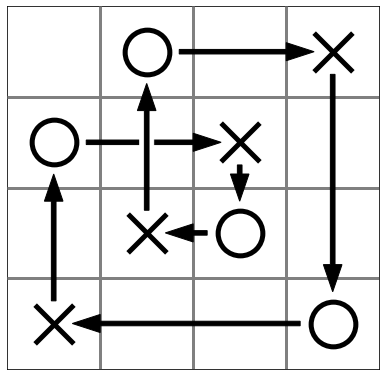

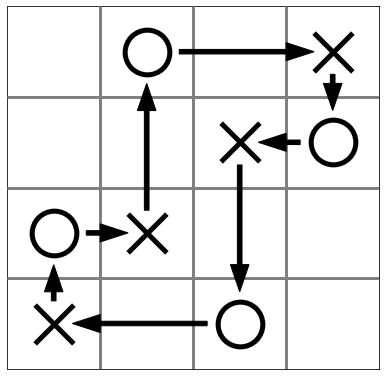

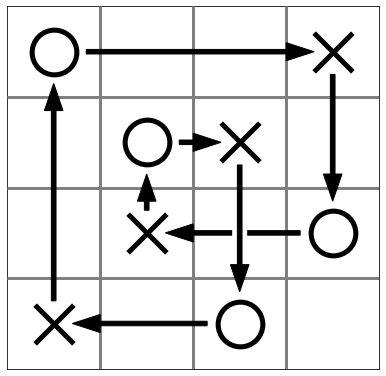

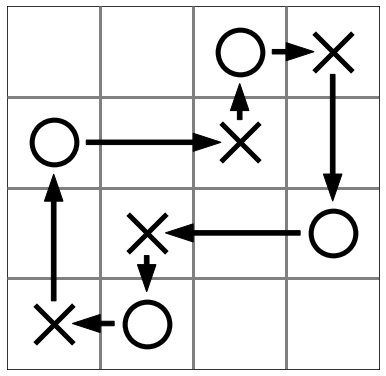

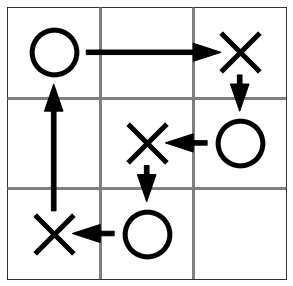

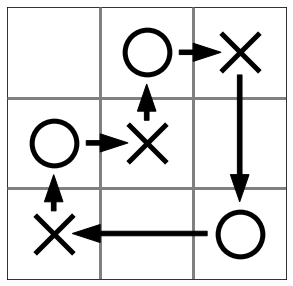

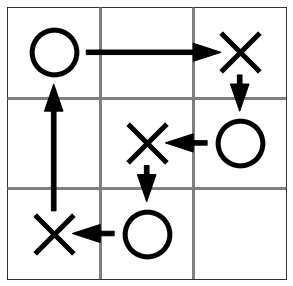

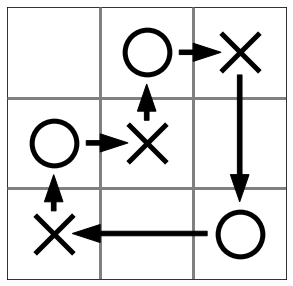

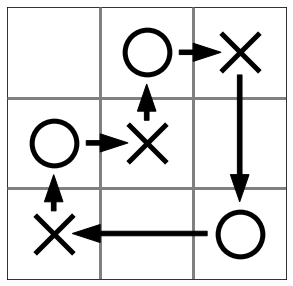

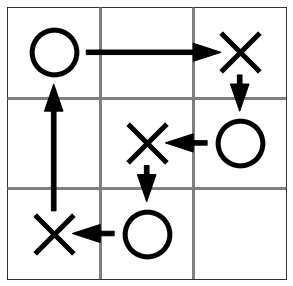

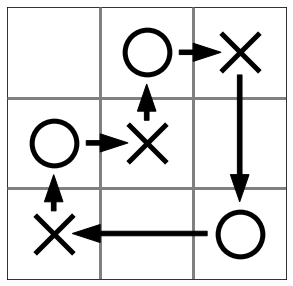

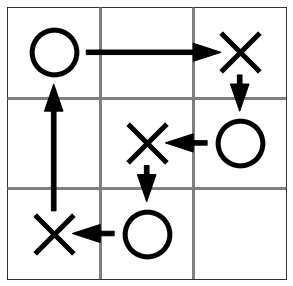

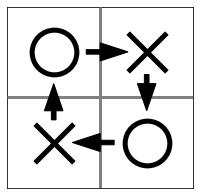

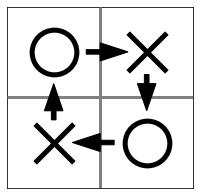

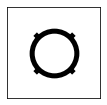

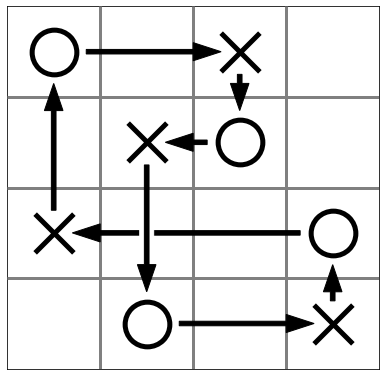

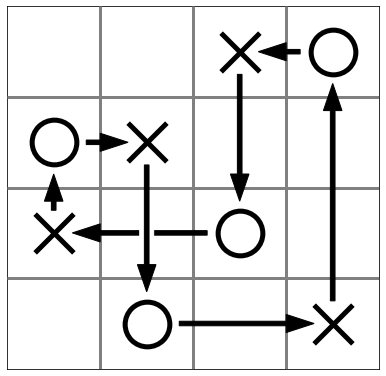

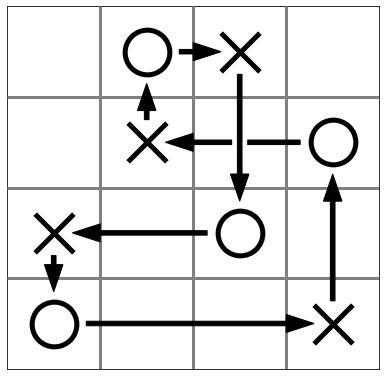

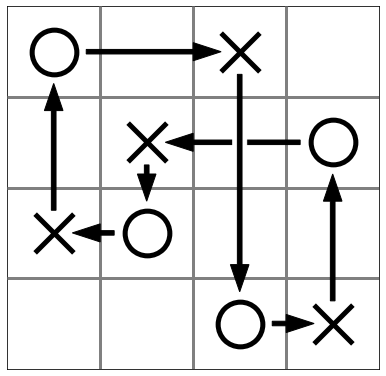

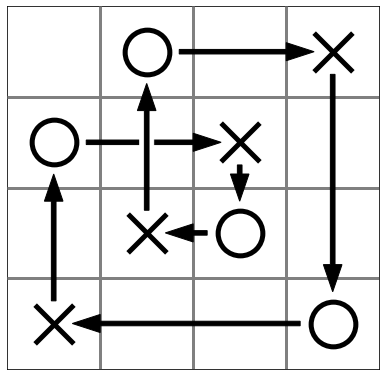

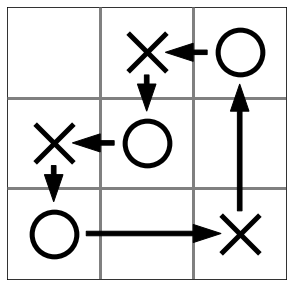

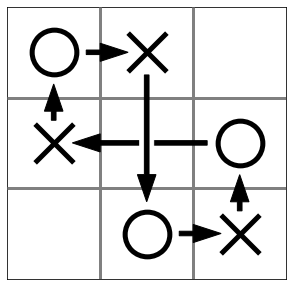

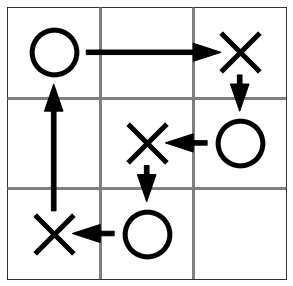

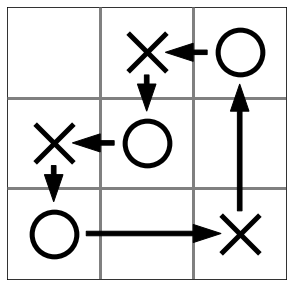

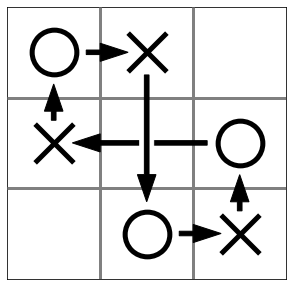

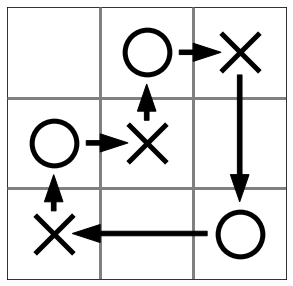

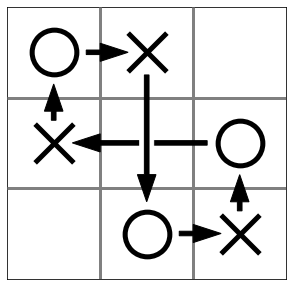

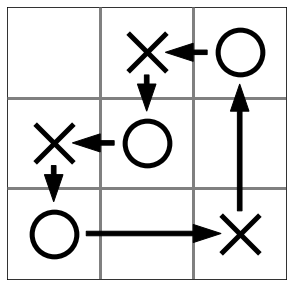

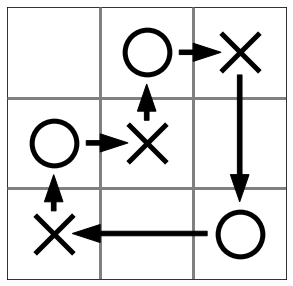

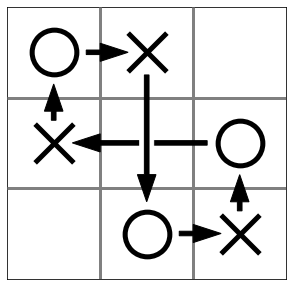

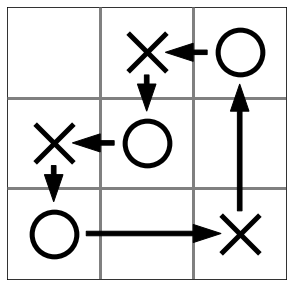

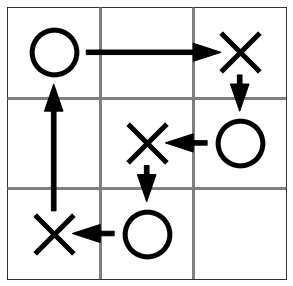

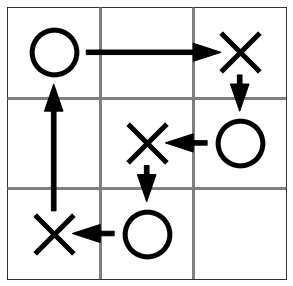

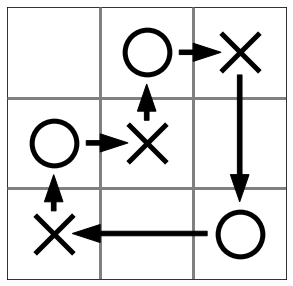

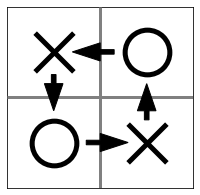

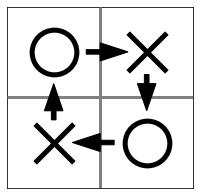

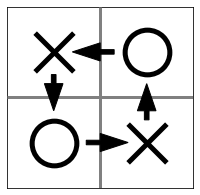

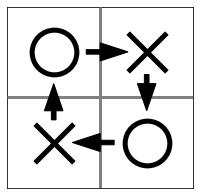

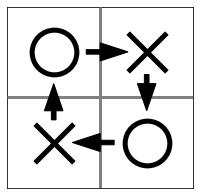

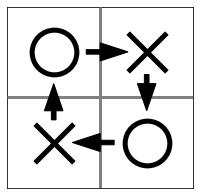

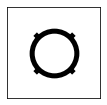

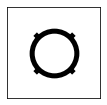

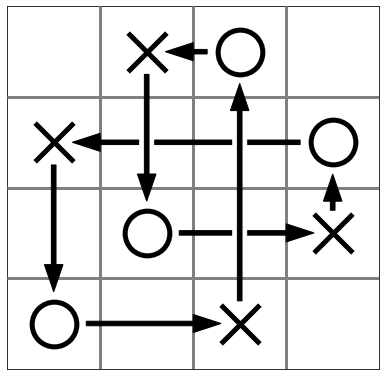

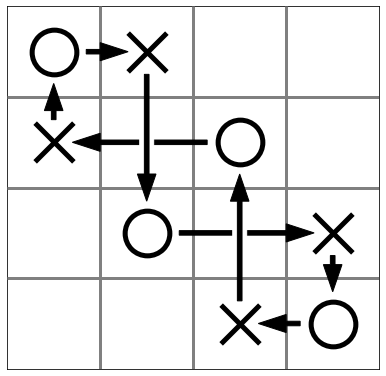

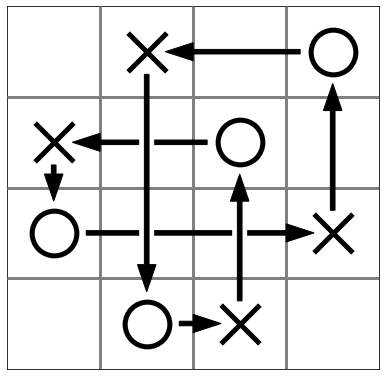

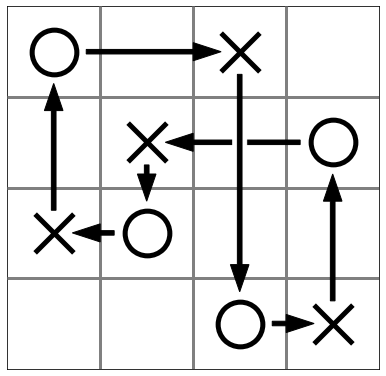

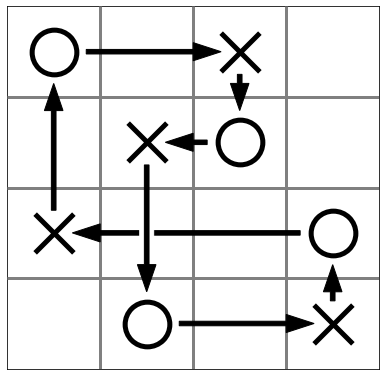

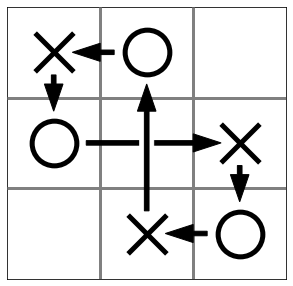

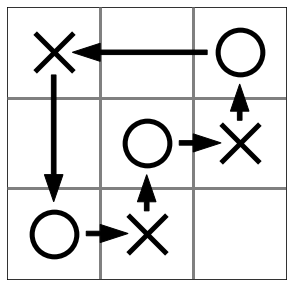

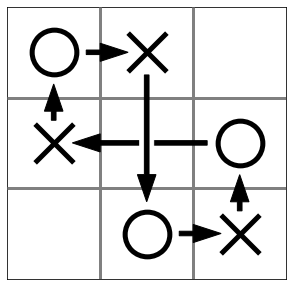

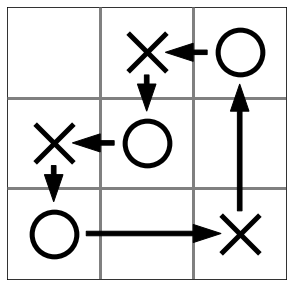

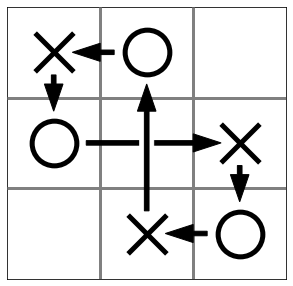

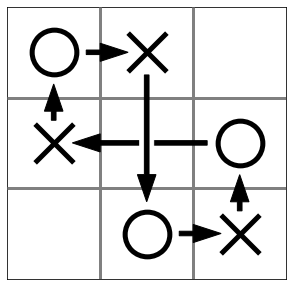

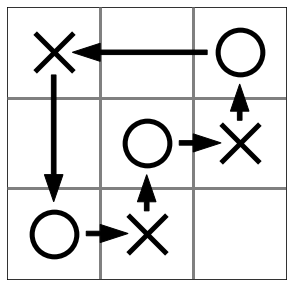

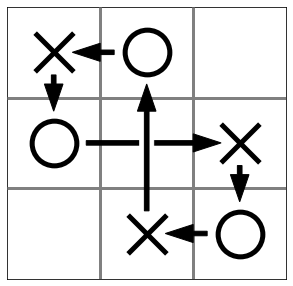

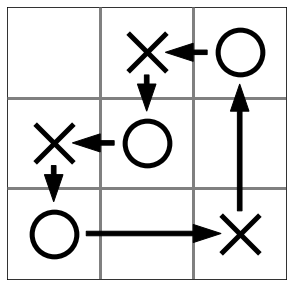

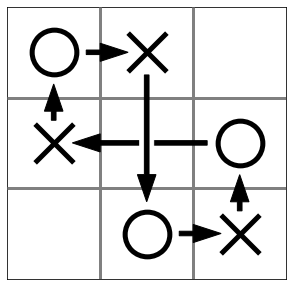

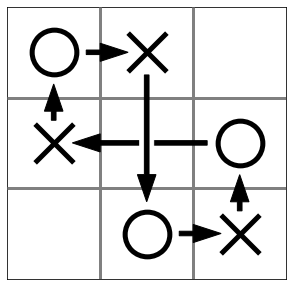

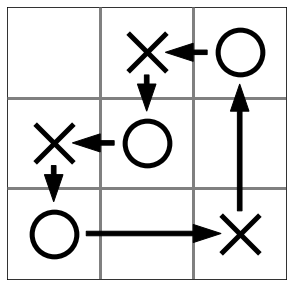

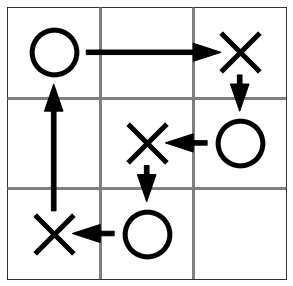

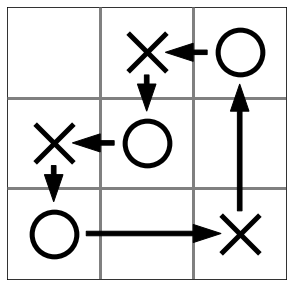

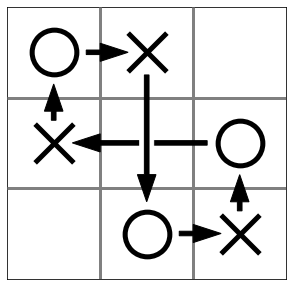

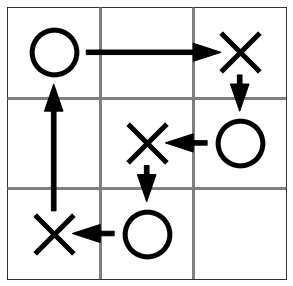

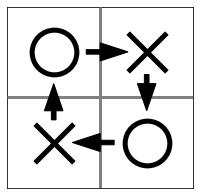

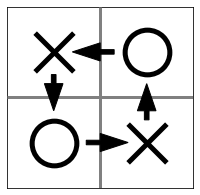

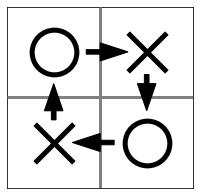

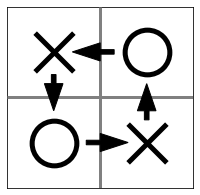

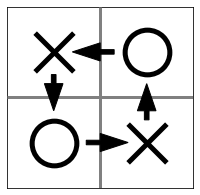

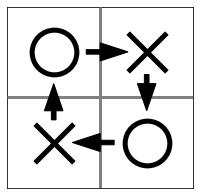

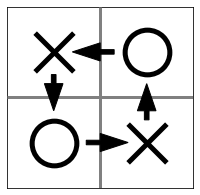

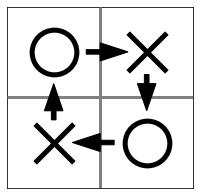

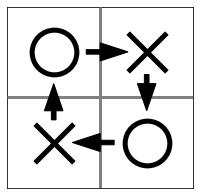

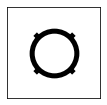

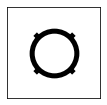

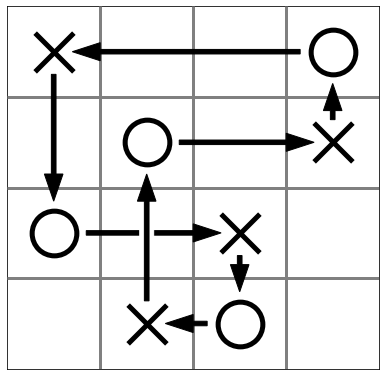

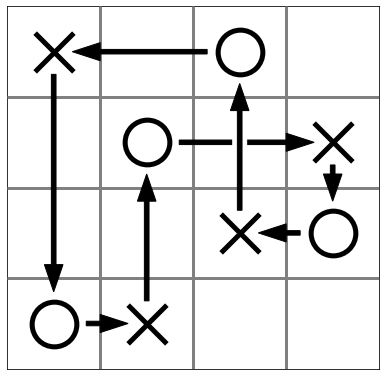

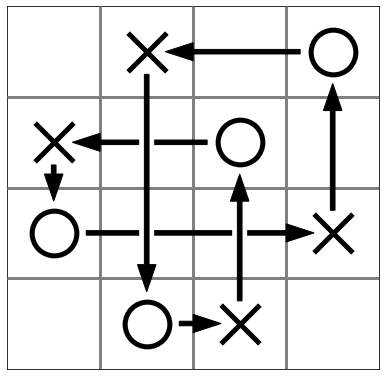

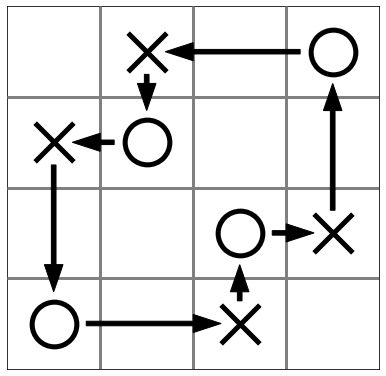

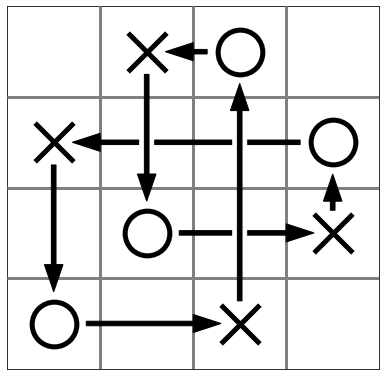

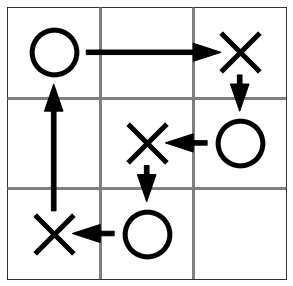

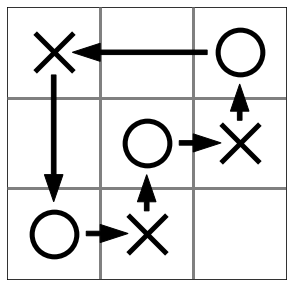

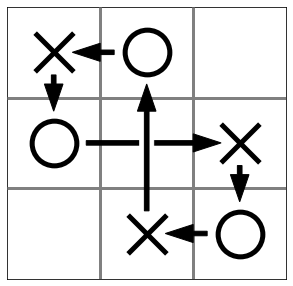

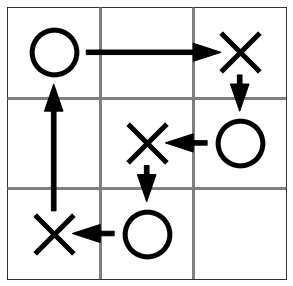

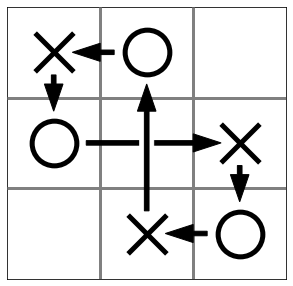

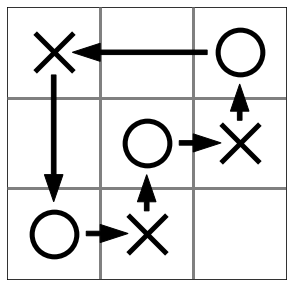

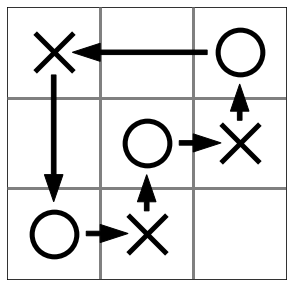

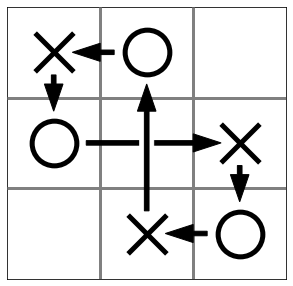

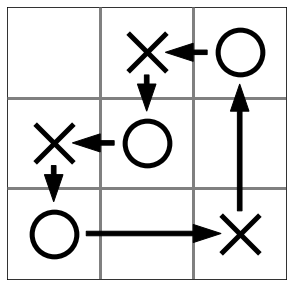

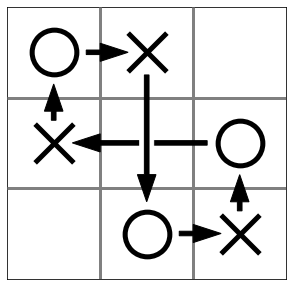

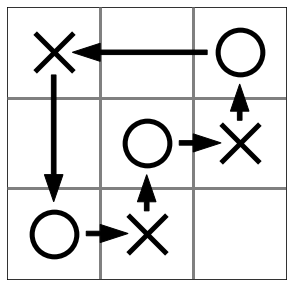

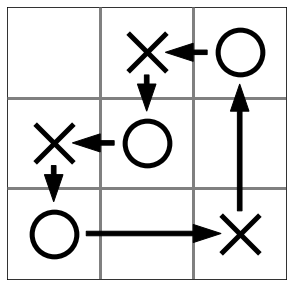

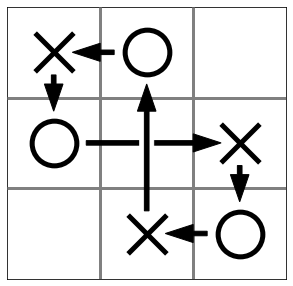

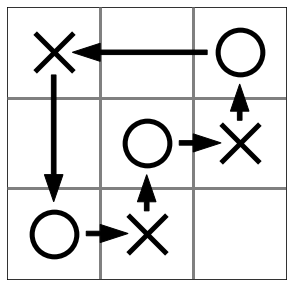

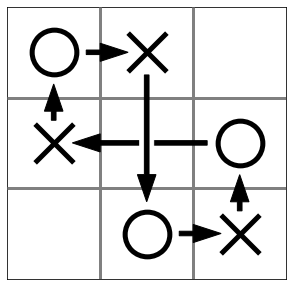

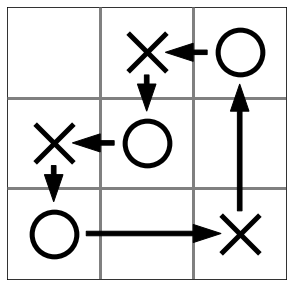

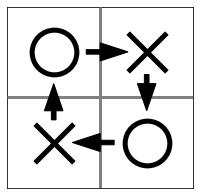

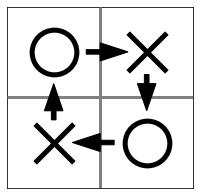

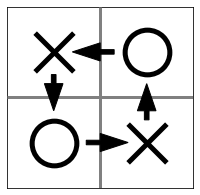

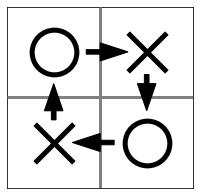

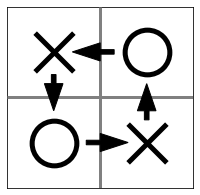

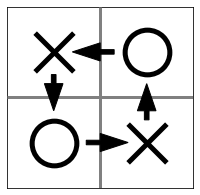

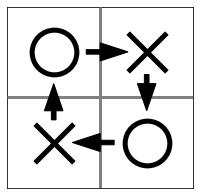

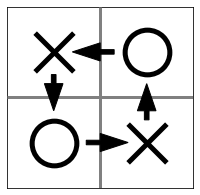

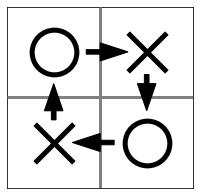

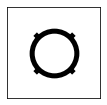

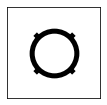

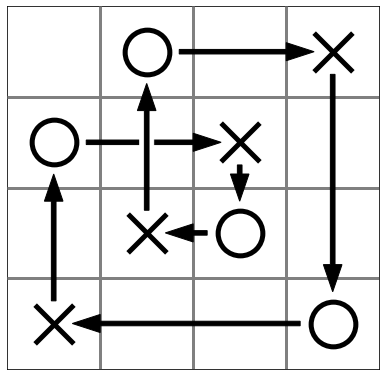

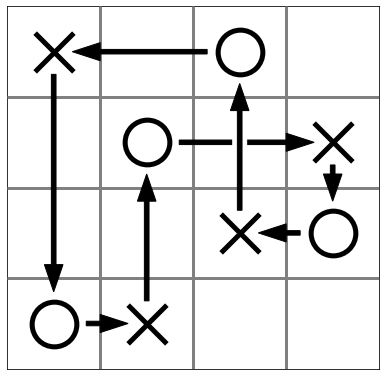

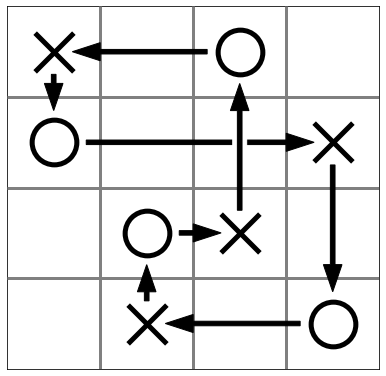

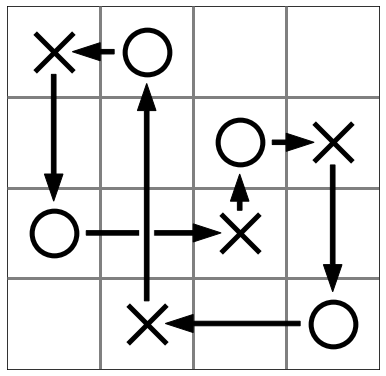

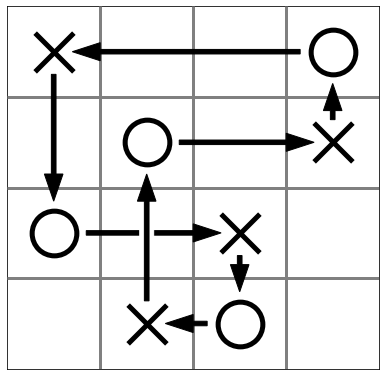

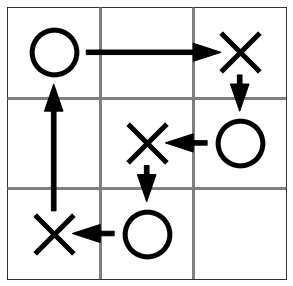

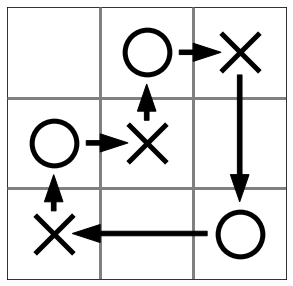

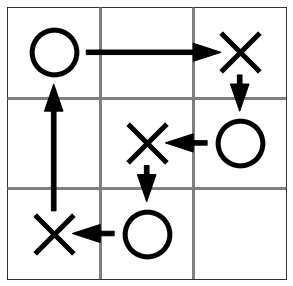

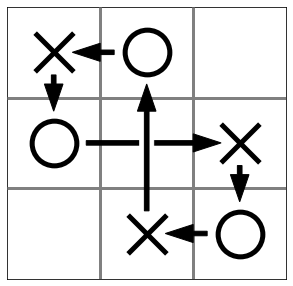

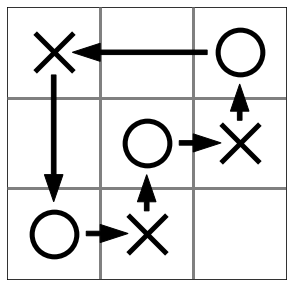

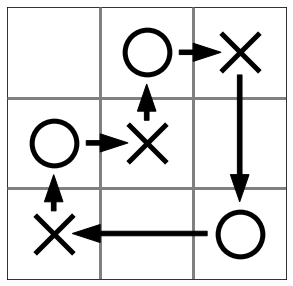

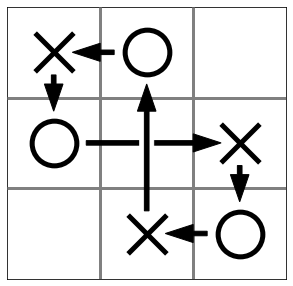

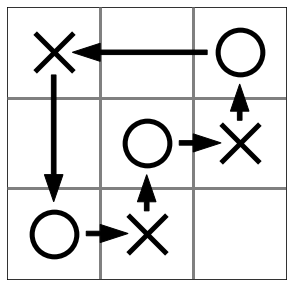

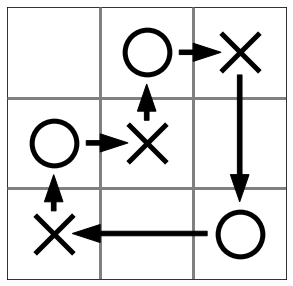

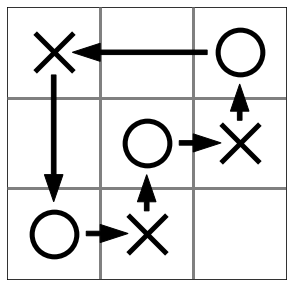

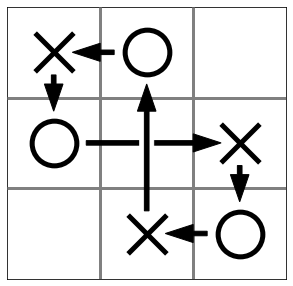

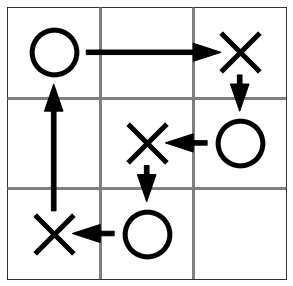

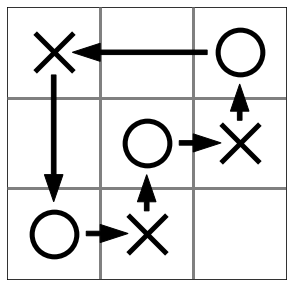

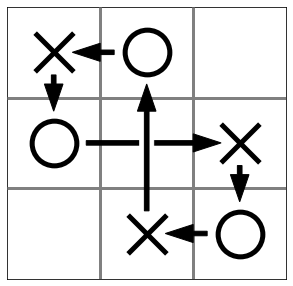

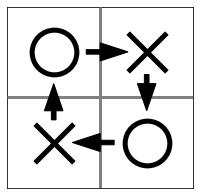

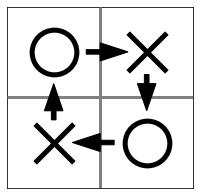

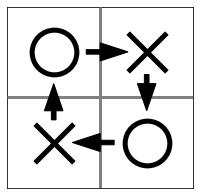

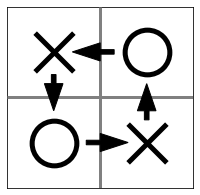

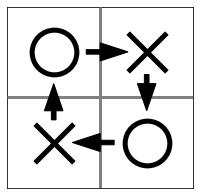

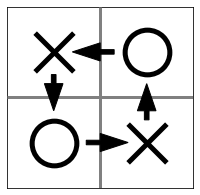

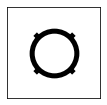

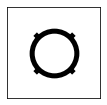

In [32]:
for x in range(5):
    G = stComplex(trefoil.h_cycle(x+1))
    adMat = nx.adjacency_matrix(G)
    
    nx.write_gml(G, "stDiffTrefoil" + str(x) + ".gml")

In [13]:
# dTrefoil = stDiff(trefoil)
# G = nx.DiGraph()
# addToGraphFromDictZ2(trefoil, dTrefoil, G)
# nx.write_gml(G, "stDiffTest.gml")

In [14]:
sig = perm([2,4,3,1])
phi = perm([4,2,3,1])

[[5, 1, 2, 3, 4], [2, 3, 4, 5, 1]]

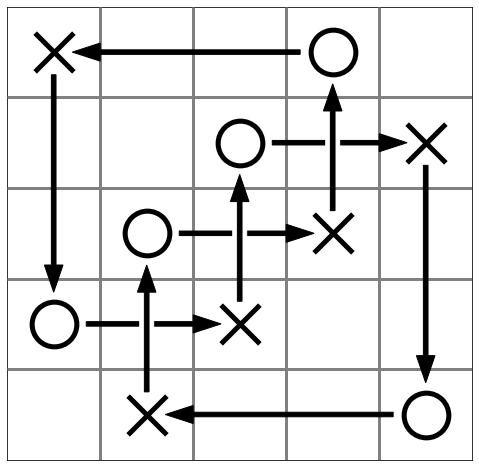

In [15]:
trefoil

[2, 3, 4, 5, 1]


[[1, 2, 3, 4, 5], [3, 4, 5, 1, 2]]

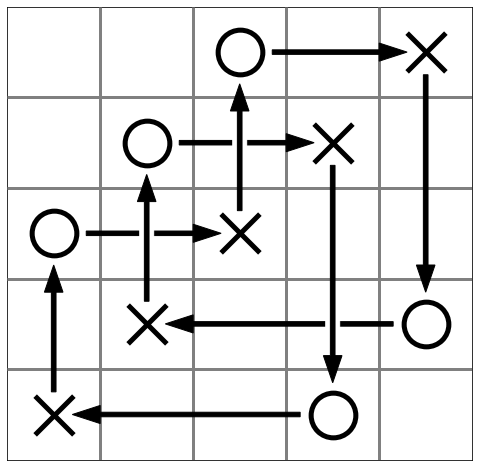

In [16]:
trefoil.h_cycle(1)

[[1, 2, 3, 4], [3, 4, 2, 1]]

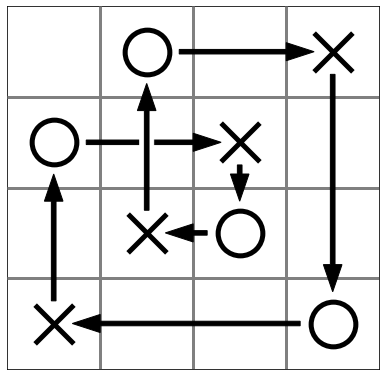

In [17]:
trefoil.x_destab(1)

{[[1, 2, 3, 4], [3, 4, 2, 1]]: 1,
 [[4, 1, 2, 3], [1, 3, 4, 2]]: 1,
 [[4, 1, 2, 3], [3, 2, 4, 1]]: 1,
 [[4, 1, 2, 3], [2, 4, 3, 1]]: 1,
 [[4, 1, 2, 3], [2, 3, 1, 4]]: 1}

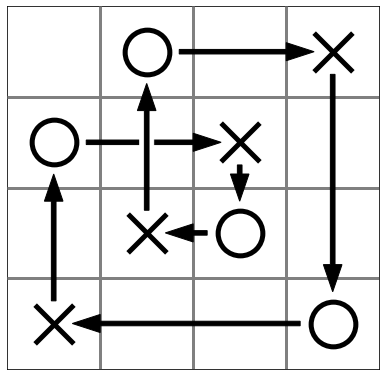

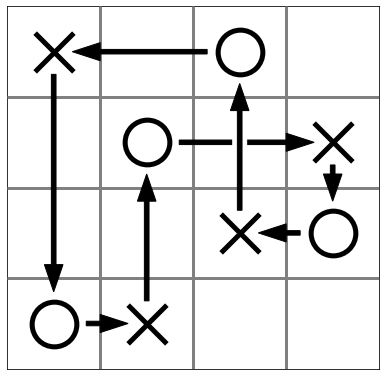

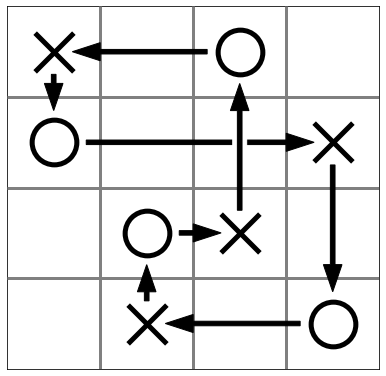

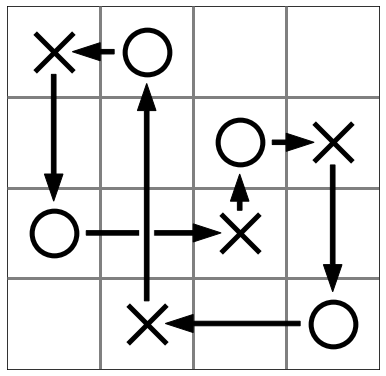

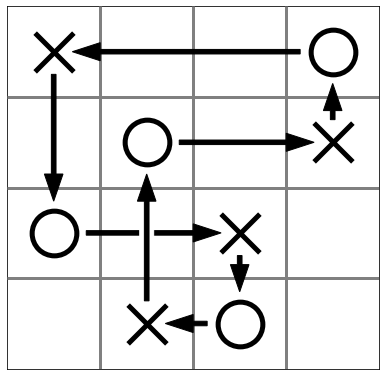

In [18]:
stDiff(trefoil)

In [19]:
test = {trefoil:1}

In [20]:
test['steve'] +=1

KeyError: 'steve'

In [ ]:
test

[[5, 1, 2, 3, 4], [2, 3, 4, 5, 1]]

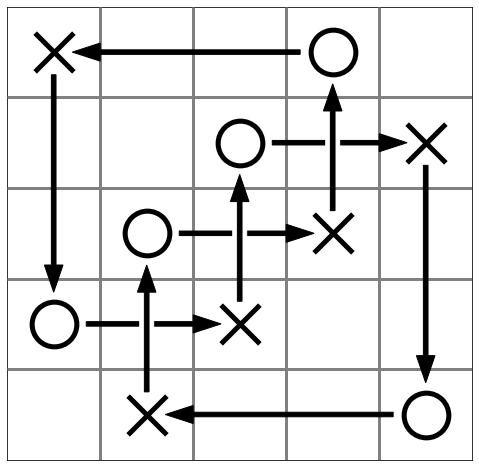

In [33]:
trefoil